In [1]:
import sys, os
import pandas as pd
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(1, '../scripts')
root = os.getcwd()


from TwintDataMiner import TwintDataMiner
from PandasDataCleaner import PandasDataCleaner
from TextBlobSentiment import TextBlobSentiment
from Visualisation import Visualisation


In [2]:
tweetsFile = "../data/tweets.csv"
tdm = TwintDataMiner()
#tdm.getAttribute("tweet", tweetsFile)

In [3]:
attributes = ["id", "tweet", "place", "time"]
df = tdm.getPandasDataFrame(attributes, tweetsFile)
df = df[:1000]
#df.head


In [4]:
pdc = PandasDataCleaner()
#df = pdc.translate(df, 'tweet', 'translatedTweet')
df  = pdc.detectLanguage(df, 'tweet', 'lang')
df = pdc.cleanTweets(df, 'tweet')

In [5]:
#only use english language tweets
df = df.loc[df['lang'] == 'en']
df = df.reset_index(drop=True)
tbs = TextBlobSentiment()
df = tbs.addSentimentToDataframe(df, display=False)

    

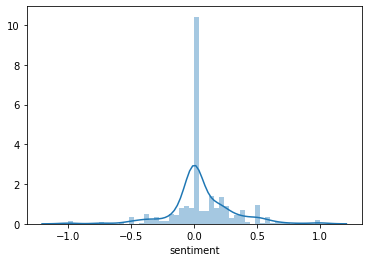

In [6]:
vis = Visualisation()
%matplotlib inline
vis.showDistribution(df, 'sentiment')

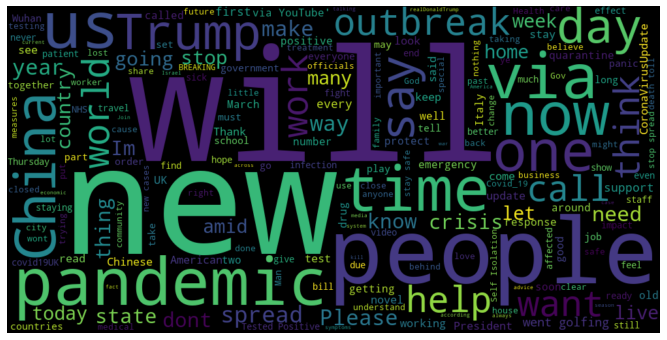

In [7]:
vis.showWordCloud(df, 'tweet')

In [9]:
pd.options.mode.chained_assignment = None
#get rid of rows without a location
placedf = df.loc[df['place'] != '']
#make column of general location
placedf = pdc.addGeneralLocation(placedf)
#make new column with count f places
countDict = placedf.groupby('genplace').count()['id'].to_dict()
placedf["genplacecount"] = placedf['genplace'].apply(lambda x: countDict[x])
#filter out places with less than 5 datapoints
placedf = placedf.loc[placedf['genplacecount'] > 4]
vis.categoricalScatterPlot(placedf, 'genplace', 'sentiment', rotation=45, height=10, fontsize=10)

ValueError: min() arg is an empty sequence

In [10]:
#file with every tweet between 12:00 and 12:01 since 1st January
tweetsFile = "../data/timeSeriesTweets.csv"
attributes = ["id", "tweet", "time", "date"]
timeseriesdf = tdm.getPandasDataFrame(attributes, tweetsFile)

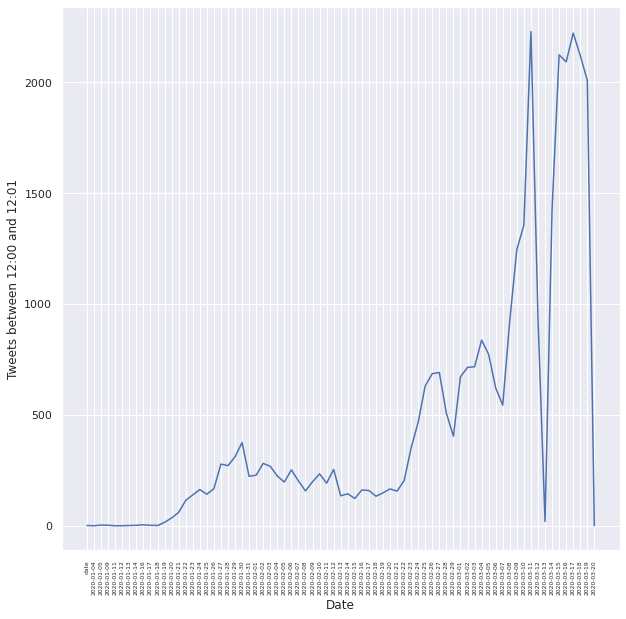

In [11]:
#plot amount of datapoints with same date
vis.plotCountOfUnique(timeseriesdf, 'date', xlabel='Date', ylabel='Tweets between 12:00 and 12:01')

In [13]:
df.shape
df.head

<bound method NDFrame.head of                       id                                              tweet  \
0    1240726794417967111  BREAKING: Germany reports 2982 new coronavirus...   
1    1240726793985941504  While staying in his Gordon Brown bunker becau...   
2    1240726793881034754  More misinformation from @realDonaldTrump #cor...   
3    1240726793306492930  My wife is convinced she has had it ( End Janu...   
4    1240726793126137857  Israeli spies source up to 100,000 coronavirus...   
..                   ...                                                ...   
544  1240726650347716609  NPR: As #Italy's #Coronavirus Deaths Pass Chin...   
545  1240726650070994946  Italy Coronavirus Death Toll Rises To 3,405 Ov...   
546  1240726649454419968  CARTE BLANCHE - Le gigantisme, prochaine victi...   
547  1240726649353666561  Please share #coronavirus #nhs pic.twitter.com...   
548  1240726649320194049  y'all realise house never actually cured thing...   

    place      time l

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

tweetList = df['tweet'].to_numpy()

# Create the bag of words feature matrix
count = CountVectorizer()
bag_of_words = count.fit_transform(tweetList)

# Show feature matrix
bow = bag_of_words.toarray()



(549, 3510)

In [61]:
def createVocabulary(words):
    vocab = dict()
    count = 0
    for word in words:
        if(not word in vocab):
            vocab[word] = count
            count += 1
    return vocab


chosenWords = ['death', 'deaths', 'ventilator', 'ventilators', 'crisis', 'scared', 'tragedy', 'struggling']

vocabulary = createVocabulary(chosenWords)
print(vocabulary)



{'death': 0, 'deaths': 1, 'ventilator': 2, 'ventilators': 3, 'crisis': 4, 'scared': 5, 'tragedy': 6, 'struggling': 7}


In [30]:
# Create the bag of words feature matrix
count = CountVectorizer(vocabulary=vocabulary)
bag_of_words = count.fit_transform(tweetList)

# Show feature matrix
bow = bag_of_words.toarray()
bow

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(bow)
x

array([[-0.12160358,  7.74596669,  0.        , ..., -0.04271788,
         0.        , -0.04271788],
       [-0.12160358, -0.12909944,  0.        , ..., -0.04271788,
         0.        , -0.04271788],
       [-0.12160358, -0.12909944,  0.        , ..., -0.04271788,
         0.        , -0.04271788],
       ...,
       [-0.12160358, -0.12909944,  0.        , ..., -0.04271788,
         0.        , -0.04271788],
       [-0.12160358, -0.12909944,  0.        , ..., -0.04271788,
         0.        , -0.04271788],
       [-0.12160358, -0.12909944,  0.        , ..., -0.04271788,
         0.        , -0.04271788]])

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pc = pca.fit_transform(x)

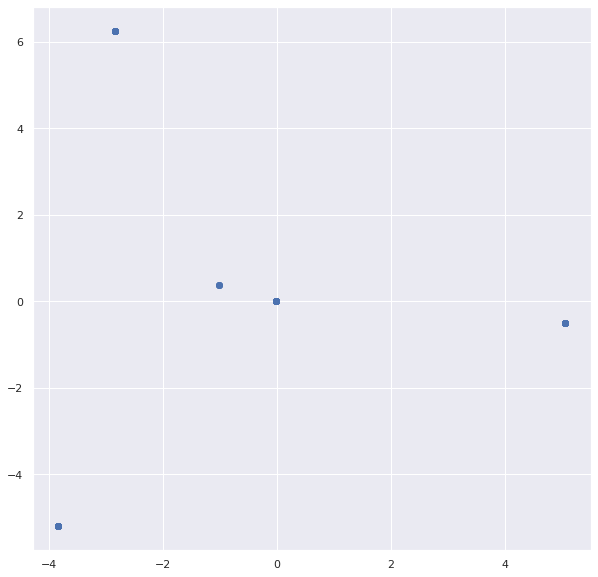

In [42]:
plt.scatter(pc[:,0], pc[:,1])
plt.show()

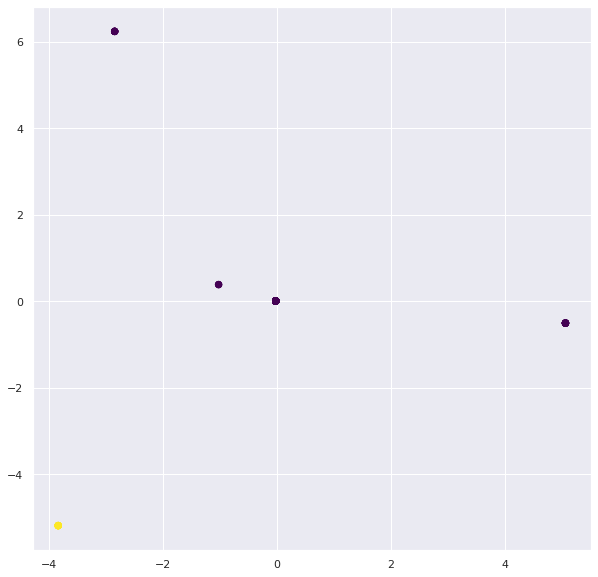

In [56]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2).fit(x)
labels = gmm.predict(x)
plt.scatter(pc[:, 0], pc[:, 1], c=labels, s=40, cmap='viridis');

In [60]:
panic = gmm.predict_proba(x)
panic

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])